In [2]:
import pandas as pd
import re
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from urllib.parse import urlparse
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import random

import time
from tqdm import tqdm



2023-11-19 17:05:33.155680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/pranaymishra/Desktop/care/.conda/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
common_regex = '^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[^\]]+)\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-)'
combined_regex = '^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[^\]]+)\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-) "(?P<referrer>[^"]*)" "(?P<useragent>[^"]*)'
columns = ['client', 'userid', 'datetime', 'method', 'request', 'status', 'size', 'referer', 'user_agent']

In [4]:
def keep_data_percent(input_file, output_file):
    # Read all lines from the input file
    with open(input_file, 'r') as f:
        lines = f.readlines()

    # Calculate the number of lines to keep
    num_lines_to_keep = int(len(lines) * 0.02)

    # Keep the first 8% of lines
    kept_lines = lines[:num_lines_to_keep]

    # Write kept lines to the output file
    with open(output_file, 'w') as f:
        f.writelines(kept_lines)

if __name__ == "__main__":
    input_file = "access.log"
    output_file = "new_file.log"

    keep_data_percent(input_file, output_file)


In [5]:
%mkdir parquet_dir

mkdir: parquet_dir: File exists


In [6]:

def logs_to_df(logfile, output_dir, errors_file):
    with open(logfile) as source_file:
        linenumber = 0
        parsed_lines = []
        for line in tqdm(source_file):
            try:
                log_line = re.findall(combined_regex, line)[0]
                parsed_lines.append(log_line)
            except Exception as e:
                with open(errors_file, 'at') as errfile:
                    print((line, str(e)), file=errfile)
                continue
            linenumber += 1
            if linenumber % 250_000 == 0:
                df = pd.DataFrame(parsed_lines, columns=columns)
                df.to_parquet(f'{output_dir}/file_{linenumber}.parquet')
                parsed_lines.clear()
        else:
            df = pd.DataFrame(parsed_lines, columns=columns)
            df.to_parquet(f'{output_dir}/file_{linenumber}.parquet')
            parsed_lines.clear()

In [7]:
logs_to_df(logfile='./new_file.log', output_dir='parquet_dir/', errors_file='errors.txt')

207303it [00:00, 249329.80it/s]


In [8]:
logs_df = pd.read_parquet('parquet_dir/')

In [9]:
logs_df['client'] = logs_df['client'].astype('category')
del logs_df['userid']
logs_df['datetime'] = pd.to_datetime(logs_df['datetime'], format='%d/%b/%Y:%H:%M:%S %z')
logs_df['method'] = logs_df['method'].astype('category')
logs_df['status'] = logs_df['status'].astype('int16')
logs_df['size'] = logs_df['size'].astype('int32')
logs_df['referer'] = logs_df['referer'].astype('category')
logs_df['user_agent'] = logs_df['user_agent'].astype('category')

In [10]:
logs_df

,client,datetime,method,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/60844/productModel/200x200,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/61474/productModel/200x200,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET,/image/14925/productModel/100x100,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
...,...,...,...,...,...,...,...,...
207293,85.10.206.20,2019-01-22 09:06:22+03:30,GET,/browse/etching-pot/%DA%AF%D9%84%D8%AF%D8%A7%25,200,30273,-,Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:...
207294,40.77.167.13,2019-01-22 09:06:22+03:30,GET,"/filter/b1,b103,b105,b109,b111,b113,b135,b144,...",200,38200,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
207295,91.99.30.32,2019-01-22 09:06:22+03:30,GET,/variationGroup/variationForm?baseProductId=20...,200,962,https://www.zanbil.ir/product/productDetails?c...,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...
207296,37.129.105.252,2019-01-22 09:06:22+03:30,GET,/image/11926?name=sm812aaa.jpg&wh=200x200,200,4377,-,Dalvik/2.1.0 (Linux; U; Android 7.1.2; Redmi N...


In [11]:
logs_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207298 entries, 0 to 207297
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype                    
---  ------      --------------   -----                    
 0   client      207298 non-null  category                 
 1   datetime    207298 non-null  datetime64[ns, UTC+03:30]
 2   method      207298 non-null  category                 
 3   request     207298 non-null  object                   
 4   status      207298 non-null  int16                    
 5   size        207298 non-null  int32                    
 6   referer     207298 non-null  category                 
 7   user_agent  207298 non-null  category                 
dtypes: category(4), datetime64[ns, UTC+03:30](1), int16(1), int32(1), object(1)
memory usage: 6.3+ MB


In [12]:
logs_df['referer'] = logs_df['referer'].str.lower()
def classify_traffic(referrer):
    if '-' in referrer and len(referrer) < 2:
        return 'direct'  
    elif any(keyword in referrer.lower() for keyword in ['google', 'bing', 'yahoo','yandex','baidu','torob','search']):
        return 'search'  
    elif any(keyword in referrer.lower() for keyword in ['facebook', 'twitter', 'linkedin','instagram','pinterest','youtube','reddit','ask','telegram']):
        return 'social'  
    else:
        return 'other'

    
logs_df['traffic-label'] = logs_df['referer'].apply(classify_traffic)

In [13]:
logs_df[logs_df['traffic-label'] == 'social'].head(10)

,client,datetime,method,request,status,size,referer,user_agent,traffic-label
4396,5.117.242.204,2019-01-22 04:13:22+03:30,GET,/settings/logo,200,4120,https://www.zanbil.ir/basket/view,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4397,5.117.242.204,2019-01-22 04:13:22+03:30,GET,/image/55839/productModel/100x100,200,2028,https://www.zanbil.ir/basket/view,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4429,5.117.242.204,2019-01-22 04:13:31+03:30,GET,/basket/checkout,200,18037,https://www.zanbil.ir/basket/view,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4433,5.117.242.204,2019-01-22 04:13:33+03:30,GET,/settings/logo,200,4120,https://www.zanbil.ir/basket/checkout,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4586,5.117.242.204,2019-01-22 04:14:16+03:30,GET,/basket/storeCustomerInformationWithoutRegistr...,302,0,https://www.zanbil.ir/basket/checkout,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4591,5.117.242.204,2019-01-22 04:14:17+03:30,GET,/basket/checkout?currentStep=2,200,20399,https://www.zanbil.ir/basket/checkout,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4601,5.117.242.204,2019-01-22 04:14:19+03:30,GET,/settings/logo,200,4120,https://www.zanbil.ir/basket/checkout?currents...,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4602,5.117.242.204,2019-01-22 04:14:20+03:30,GET,/basket/provinces?__amp_source_origin=https%3A...,200,444,https://www.zanbil.ir/basket/checkout?currents...,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4603,5.117.242.204,2019-01-22 04:14:20+03:30,GET,/basket/cities?__amp_source_origin=https%3A%2F...,200,389,https://www.zanbil.ir/basket/checkout?currents...,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4604,5.117.242.204,2019-01-22 04:14:20+03:30,GET,/province/json?__amp_source_origin=https%3A%2F...,200,5212,https://www.zanbil.ir/basket/checkout?currents...,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social


In [14]:
def extract_netloc(url):
    parsed_url = urlparse(url)
    return parsed_url.netloc
logs_df['ref'] = logs_df['referer'].apply(extract_netloc)
logs_df

,client,datetime,method,request,status,size,referer,user_agent,traffic-label,ref
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,direct,
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/60844/productModel/200x200,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,other,www.zanbil.ir
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/61474/productModel/200x200,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,other,www.zanbil.ir
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET,/image/14925/productModel/100x100,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,direct,
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,direct,
...,...,...,...,...,...,...,...,...,...,...
207293,85.10.206.20,2019-01-22 09:06:22+03:30,GET,/browse/etching-pot/%DA%AF%D9%84%D8%AF%D8%A7%25,200,30273,-,Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:...,direct,
207294,40.77.167.13,2019-01-22 09:06:22+03:30,GET,"/filter/b1,b103,b105,b109,b111,b113,b135,b144,...",200,38200,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,direct,
207295,91.99.30.32,2019-01-22 09:06:22+03:30,GET,/variationGroup/variationForm?baseProductId=20...,200,962,https://www.zanbil.ir/product/productdetails?c...,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,other,www.zanbil.ir
207296,37.129.105.252,2019-01-22 09:06:22+03:30,GET,/image/11926?name=sm812aaa.jpg&wh=200x200,200,4377,-,Dalvik/2.1.0 (Linux; U; Android 7.1.2; Redmi N...,direct,


In [15]:
threshold = 75 
logs_df['refers'] = ''

def compare_urls(url1, url2):
    return fuzz.ratio(url1, url2)
canonical_urls = {}

for idx, url in enumerate(logs_df['ref']):
    canonical_url = None
    for key, value in canonical_urls.items():
        if compare_urls(url, key) >= threshold:
            canonical_url = key
            break
    
    if canonical_url is None:
        canonical_url = url
        canonical_urls[canonical_url] = canonical_url
    
    logs_df.at[idx, 'refers'] = canonical_url


In [16]:
logs_df['refers'].value_counts()

refers
www.zanbil.ir                              135426
                                            58245
znbl.ir                                      8191
torob.com                                    2035
www-zanbil-ir.cdn.ampproject.org             1438
www.google.com                               1401
emalls.ir                                     139
ptcnovin.com                                  135
arzoonyab.com                                  64
www.ask.ir                                     53
com.google.android.googlequicksearchbox        38
irantradeco.ir                                 24
www.khanesazan.com                             14
www.webgardii.ir                               12
www.homepars.com                                8
com.google.android.gm                           8
www.bing.com                                    8
gahar.ir                                        5
search.mysearch.com                             5
newsboxi.ir                                

In [19]:
url_counts = logs_df['refers'].value_counts()

less_than_10_counts = url_counts[url_counts < 10]

unique_urls_less_than_10 = len(less_than_10_counts)
print("UNIQUE URLS LESS THAN 10:", unique_urls_less_than_10)
logs_df = logs_df[logs_df['refers'].isin(less_than_10_counts.index) == False]
print(unique_urls_less_than_10)

UNIQUE URLS LESS THAN 10: 0
0


In [20]:
url_counts = logs_df['ref'].value_counts()

more_than_10_counts = url_counts[url_counts > 500]

unique_urls_more_than_10 = more_than_10_counts.index.tolist()
print("UNIQUE URLS MORE THAN 10:", len(unique_urls_more_than_10))
print(unique_urls_more_than_10)

UNIQUE URLS MORE THAN 10: 6
['www.zanbil.ir', '', 'znbl.ir', 'torob.com', 'www-zanbil-ir.cdn.ampproject.org', 'www.google.com']


In [21]:
threshold = 25 
logs_df['user-agent'] = ''
logs_df['user_agent'] = logs_df['user_agent'].str.lower()
def compare_urls(url1, url2):
    return fuzz.ratio(url1, url2)
canonical_urls = {}

for idx, url in enumerate(logs_df['user_agent']):
    canonical_url = None
    for key, value in canonical_urls.items():
        if compare_urls(url, key) >= threshold:
            canonical_url = key
            break
    
    if canonical_url is None:
        canonical_url = url
        canonical_urls[canonical_url] = canonical_url
    
    logs_df.at[idx, 'user-agent'] = canonical_url

In [22]:
logs_df['user-agent'].value_counts()

user-agent
mozilla/5.0 (compatible; ahrefsbot/6.1; +http://ahrefs.com/robot/)                                                                                177135
mozilla/5.0 (linux; android 6.0; ale-l21 build/huaweiale-l21) applewebkit/537.36 (khtml, like gecko) chrome/66.0.3359.158 mobile safari/537.36     27526
googlebot-image/1.0                                                                                                                                 1415
torob/5 cfnetwork/976 darwin/18.2.0                                                                                                                  576
-                                                                                                                                                    550
                                                                                                                                                      83
curl/7.16.3 (amd64-portbld-freebsd7.0) libcurl/7.16.3 openssl/0.9.8e zl

In [23]:
encoder = LabelEncoder()
logs_df.loc[:, 'encoded_refers'] = encoder.fit_transform(logs_df['refers'])

unique_codes = logs_df['encoded_refers'].unique()
num_unique_urls = len(unique_codes)
print("Уникальные коды:", unique_codes)
print("Количество уникальных URL-адресов:", num_unique_urls)

Уникальные коды: [ 0 12  7  6  5 13  9  3  2  8  4 10 11  1 14]
Количество уникальных URL-адресов: 15


In [24]:
logs_df.loc[:, 'encoded_user-agent'] = encoder.fit_transform(logs_df['user-agent'])
logs_df.loc[:, 'encoded_status'] = encoder.fit_transform(logs_df['status'])
logs_df.loc[:, 'encoded_method'] = encoder.fit_transform(logs_df['method'])
logs_df['traffic-label'] = encoder.fit_transform(logs_df['traffic-label'])
print(logs_df['traffic-label'].value_counts())

traffic-label
1    141559
0     58245
2      6540
3       871
4        83
Name: count, dtype: int64


In [25]:
logs_df = logs_df.dropna()

In [26]:
logs_df.isnull().sum()

client                0
datetime              0
method                0
request               0
status                0
size                  0
referer               0
user_agent            0
traffic-label         0
ref                   0
refers                0
user-agent            0
encoded_refers        0
encoded_user-agent    0
encoded_status        0
encoded_method        0
dtype: int64

In [27]:
logs_df

,client,datetime,method,request,status,size,referer,user_agent,traffic-label,ref,refers,user-agent,encoded_refers,encoded_user-agent,encoded_status,encoded_method
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,200.0,30577.0,-,mozilla/5.0 (compatible; ahrefsbot/6.1; +http:...,0,,,mozilla/5.0 (compatible; ahrefsbot/6.1; +http:...,0,6,0,0
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/60844/productModel/200x200,200.0,5667.0,https://www.zanbil.ir/m/filter/b113,mozilla/5.0 (linux; android 6.0; ale-l21 build...,1,www.zanbil.ir,www.zanbil.ir,mozilla/5.0 (linux; android 6.0; ale-l21 build...,12,7,0,0
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/61474/productModel/200x200,200.0,5379.0,https://www.zanbil.ir/m/filter/b113,mozilla/5.0 (linux; android 6.0; ale-l21 build...,1,www.zanbil.ir,www.zanbil.ir,mozilla/5.0 (linux; android 6.0; ale-l21 build...,12,7,0,0
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET,/image/14925/productModel/100x100,200.0,1696.0,-,mozilla/5.0 (compatible; bingbot/2.0; +http://...,0,,,mozilla/5.0 (compatible; ahrefsbot/6.1; +http:...,0,6,0,0
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200.0,41483.0,-,mozilla/5.0 (windows nt 6.2; win64; x64; rv:16...,0,,,mozilla/5.0 (compatible; ahrefsbot/6.1; +http:...,0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207293,85.10.206.20,2019-01-22 09:06:22+03:30,GET,/browse/etching-pot/%DA%AF%D9%84%D8%AF%D8%A7%25,200.0,30273.0,-,mozilla/5.0 (compatible; mj12bot/v1.4.8; http:...,0,,,,0,0,0,0
207294,40.77.167.13,2019-01-22 09:06:22+03:30,GET,"/filter/b1,b103,b105,b109,b111,b113,b135,b144,...",200.0,38200.0,-,mozilla/5.0 (compatible; bingbot/2.0; +http://...,0,,,,0,0,0,0
207295,91.99.30.32,2019-01-22 09:06:22+03:30,GET,/variationGroup/variationForm?baseProductId=20...,200.0,962.0,https://www.zanbil.ir/product/productdetails?c...,mozilla/5.0 (windows nt 10.0; win64; x64; rv:6...,1,www.zanbil.ir,www.zanbil.ir,,12,0,0,0
207296,37.129.105.252,2019-01-22 09:06:22+03:30,GET,/image/11926?name=sm812aaa.jpg&wh=200x200,200.0,4377.0,-,dalvik/2.1.0 (linux; u; android 7.1.2; redmi n...,0,,,,0,0,0,0


In [31]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


In [37]:
features = [
    'encoded_refers', 'encoded_user-agent', 'encoded_status', 'encoded_method'
]

In [38]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(logs_df[features])

In [39]:
isolation_model = IsolationForest(contamination=0.05, random_state=42)
isolation_model.fit(scaled_data)

IsolationForest(contamination=0.05, random_state=42)

In [40]:
import matplotlib.pyplot as plt

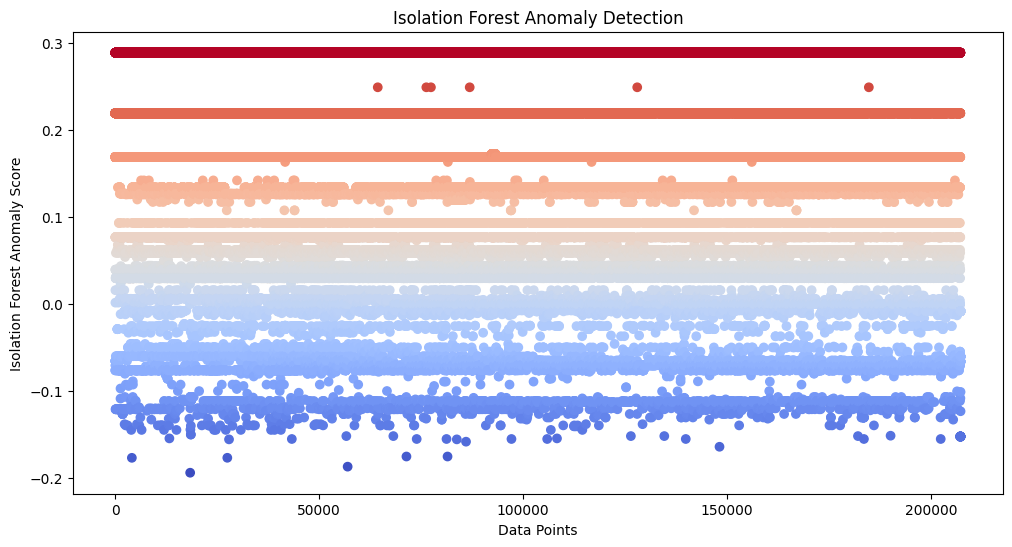

In [41]:
isolation_scores = isolation_model.decision_function(scaled_data)


plt.figure(figsize=(12, 6))
plt.scatter(range(len(scaled_data)), isolation_scores, c=isolation_scores, cmap='coolwarm')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Data Points')
plt.ylabel('Isolation Forest Anomaly Score')
plt.show()

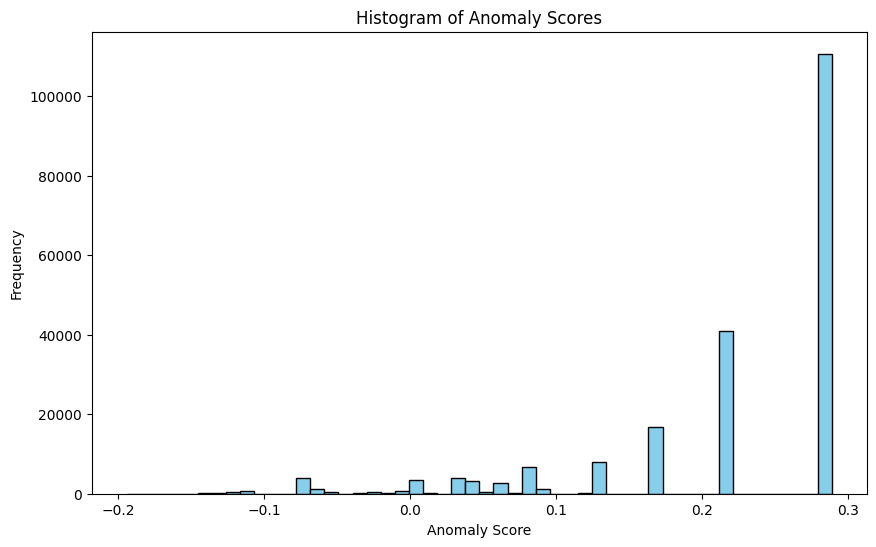

In [43]:
plt.figure(figsize=(10, 6))
plt.hist(isolation_scores, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()
